In [4]:
import os
import time
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
# set path to folder containing clinic watch data
clinicpath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to folder containing home watch data
homepath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Patient Record Correlation'
# set path to destination folder
features = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [6]:
# generate task abbreviation dictionary
ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [7]:
DataFeatures = pd.read_csv(os.path.join(features, 'Clinic Data', 'ClinicDataFeaturesX.csv'))
DataFeatures.head()

,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,RMSX,RMSY,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
0,1003.0,0,Drnkg,0,1.0,1.0,0.0,1.0,0.003307,0.002409,...,1.280704,1.386294,1.396967,0.000703,0.065298,0.006188,0.009186,3.487845,14.708341,0.012476
1,1003.0,0,Drnkg,1,1.0,1.0,0.0,1.0,0.005253,0.008123,...,0.959580,0.575852,0.742688,0.005957,0.897089,0.034245,0.087334,6.468010,51.769176,0.011136
2,1003.0,0,Drnkg,2,1.0,1.0,0.0,1.0,0.005203,0.009098,...,1.217019,0.722551,0.846374,0.006222,0.897081,0.042083,0.088483,6.029726,46.903740,0.011594
3,1003.0,0,Drnkg,3,1.0,1.0,0.0,1.0,0.004530,0.006995,...,1.207064,0.759448,0.988522,0.002867,0.262082,0.024327,0.038040,2.970488,10.522799,0.014210
4,1003.0,0,Drnkg,4,1.0,1.0,0.0,1.0,0.006927,0.013675,...,1.319454,0.953987,1.503321,0.007170,0.752276,0.065797,0.091757,3.083533,14.513282,0.016023


In [8]:
features_list = list(DataFeatures.columns[8:])
MetaData = DataFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall']]
Features = StandardScaler().fit_transform(DataFeatures[features_list].values)

pca = PCA(n_components = 3)
princComp = pca.fit_transform(Features)
princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2', 'PC3'])
DataPCA = pd.concat([MetaData, princComp], axis = 1)
DataPCA.head()

,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,PC1,PC2,PC3
0,1003.0,0,Drnkg,0,1.0,1.0,0.0,1.0,-1.876328,0.759230,-0.688164
1,1003.0,0,Drnkg,1,1.0,1.0,0.0,1.0,0.213879,3.029143,-2.034445
2,1003.0,0,Drnkg,2,1.0,1.0,0.0,1.0,0.205672,2.509804,-1.690079
3,1003.0,0,Drnkg,3,1.0,1.0,0.0,1.0,-0.607318,0.473541,-1.565706
4,1003.0,0,Drnkg,4,1.0,1.0,0.0,1.0,0.243753,-0.335153,-0.411043


In [9]:
def plotPCA(sympt, tasks, scored, comp):
    
    features_list = list(DataFeatures.columns[8:])
    MetaData = DataFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall']]
    Features = StandardScaler().fit_transform(DataFeatures[features_list].values)

    pca = PCA(n_components = comp)
    princComp = pca.fit_transform(Features)
    if comp == 3:
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2', 'PC3'])
    if comp == 2:
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2'])
    
    DataPCA = pd.concat([MetaData, princComp], axis = 1)
    indices = (x for x in range(len(DataPCA)) if DataPCA.TaskAbb.values[x] in tasks)
    DataPCA = DataPCA.loc[indices]
    
    if comp == 3:
        fig = plt.figure(figsize = (16, 12))
        ax = Axes3D(fig)
    if comp == 2:
        plt.figure(figsize = (16, 12))
    if scored:
        Scores = list(DataPCA[sympt].unique())
    else:
        Scores = ['Symptomatic', 'Non-Symptomatic']
    for score in Scores:
        if not type(score) == str:
            if np.isnan(score):
                continue
        if scored or sympt == 'TaskAbb':
            ScoreData = DataPCA[DataPCA[sympt] == score]
        elif score == 'Symptomatic':
            ScoreData = DataPCA[DataPCA[sympt] > 0]
        elif score == 'Non-Symptomatic':
            ScoreData = DataPCA[DataPCA[sympt] == 0]
        if comp == 3:
            ax.scatter(ScoreData.PC1.values, ScoreData.PC2.values, ScoreData.PC3.values)
        if comp == 2:
            plt.scatter(ScoreData.PC1.values, ScoreData.PC2.values)
    plt.legend(Scores)
    plt.xlabel('Principle Component 1')
    plt.ylabel('Principle Component 2')
    if comp == 3:
        ax.set_zlabel('Principle Component 3')
        
#     ax.set_zlim3d(-5, 10)
#     ax.set_ylim3d(-10, 5)
#     ax.set_xlim3d(-5, 10)
    
    return DataPCA

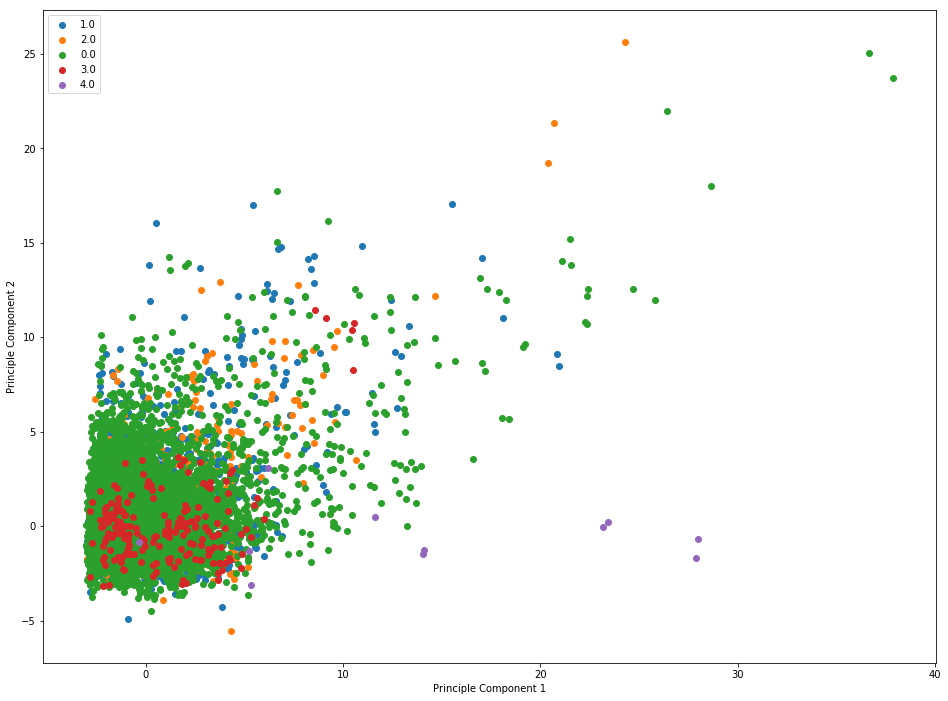

In [10]:
### TASKS
# tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt']
# tasks = ['RamL', 'RamR']
# tasks = ['FtnL', 'FtnR']
# tasks = ['Sitng', 'Stndg', 'Drwg']
# tasks = ['Wlkg', 'WlkgCnt']
tasks = ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']

### LABEL_TYPE
# label_type = 'TaskAbb'
label_type = 'Tremor'
# label_type = 'Bradykinesia'
# label_type = 'Dyskinesia'
# label_type = 'Overall'

DataPCA = plotPCA(label_type, tasks, True, 2)

In [54]:
def TrainTestCluster(label_type, tasks, newLab, groups, bestFeatIdx):
    
    pd.options.mode.chained_assignment = None
    
    if newLab:
        km = KMeans(n_clusters = len(newLab))
    else:
        km = KMeans(n_clusters = len(tasks))
    
    DataFeatures = pd.read_csv(os.path.join(features, 'Clinic Data', 'ClinicDataFeaturesX.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    if type(DataFeatures[label_type].values[-1]) != str:
        DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
        DataFeatures = DataFeatures[DataFeatures[label_type].apply(lambda x: groupDict[x]) != 'Excld']
        
    features_list = list(DataFeatures.columns[8:])
    
    if bestFeatIdx:
        best_features_list = []
        for idx in bestFeatIdx:
            best_features_list = best_features_list + [features_list[idx]]
        features_list = best_features_list
        
    print('Target Label: ' + label_type)
    print('--------------------------------------------------')
    print('Tasks Considered:')
    for task in DataFeatures.TaskAbb.unique():
        print('    ' + ClinicTasks[task])
    if newLab:
        print('--------------------------------------------------')
        print('Label Groups:')
        for label in newLab:
            print('    ' + label)
    
    DataClusters = pd.DataFrame()
    
    for subj in DataFeatures.SubjID.unique():
        
        SubjFeatures = DataFeatures[DataFeatures.SubjID == subj]
        X = SubjFeatures[features_list].values
        
        km.fit(X)
        
        ClusterLab = km.labels_
        SubjFeatures['Cluster'] = ClusterLab
        cols = ['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall', 'Cluster'] + features_list
        SubjFeatures = SubjFeatures[cols]
        if DataClusters.empty:
            DataClusters = SubjFeatures
            continue
        DataClusters = pd.concat([DataClusters, SubjFeatures], ignore_index = True)
        
        
        
        MetaData = SubjFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                                 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall', 'Cluster']]
        Features = StandardScaler().fit_transform(SubjFeatures[features_list].values)

        pca = PCA(n_components = 2)
        princComp = pca.fit_transform(Features)
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2'], index = MetaData.index)

        # CURRENT ISSUE WITH CONCATENATION
        DataPCA = pd.concat([MetaData, princComp], axis = 1)

        plt.figure(figsize = (8, 6))
        
        Clusters = list(DataPCA.Cluster.unique())
        
        for cluster in Clusters:
            ClusterData = DataPCA[DataPCA.Cluster == cluster]
            plt.scatter(ClusterData.PC1.values, ClusterData.PC2.values)
        plt.legend(Clusters)
        plt.xlabel('Principle Component 1')
        plt.ylabel('Principle Component 2')
        plt.show()
        
    return DataClusters, km

Target Label: Tremor
--------------------------------------------------
Tasks Considered:
    Drawing on a paper
    Sitting
    Standing
--------------------------------------------------
Label Groups:
    NoSymp
    Symp


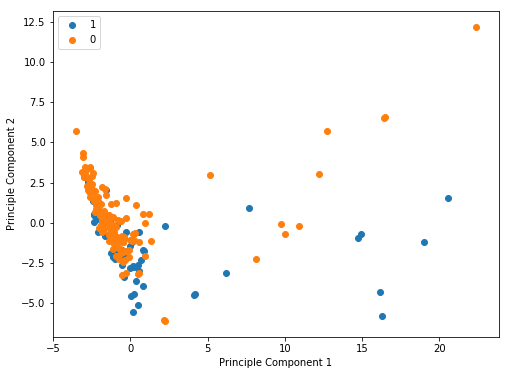

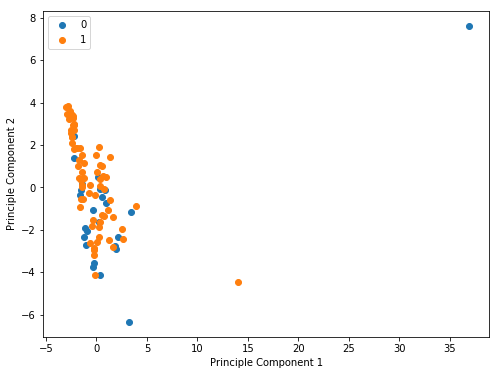

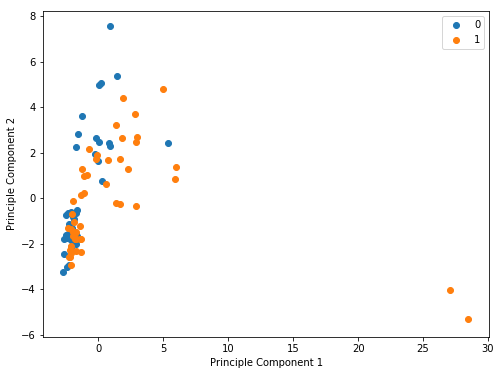

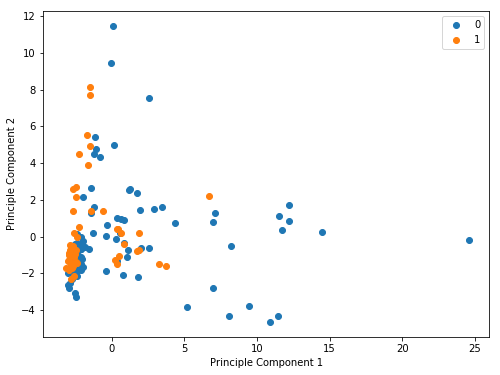

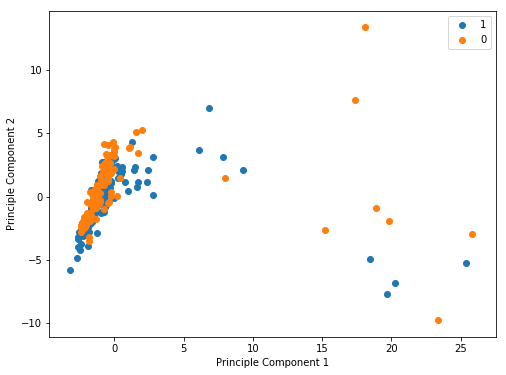

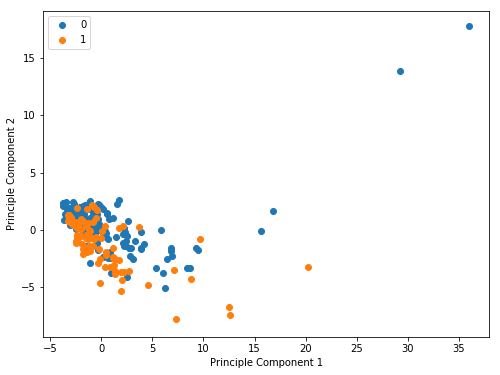

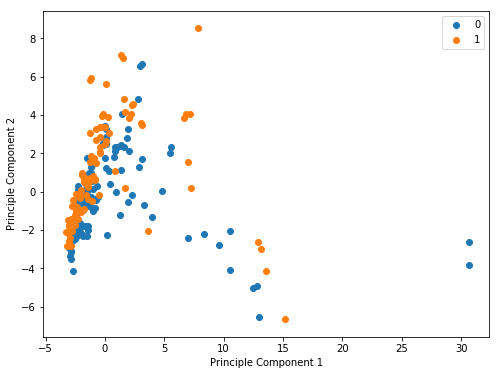

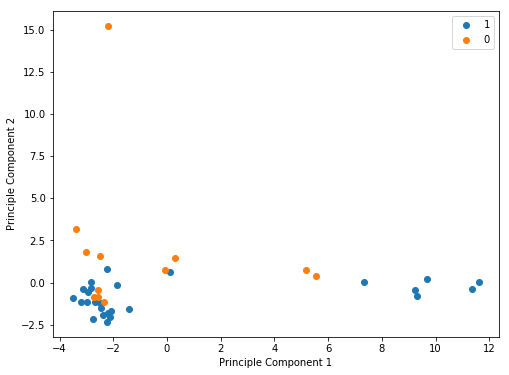

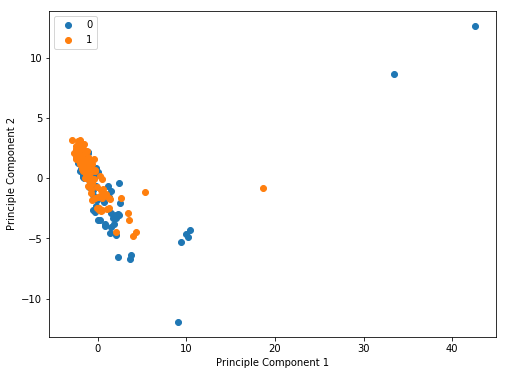

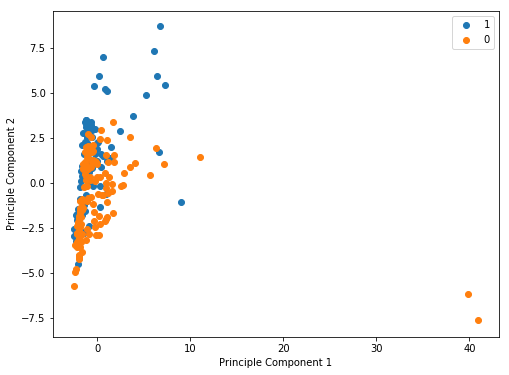

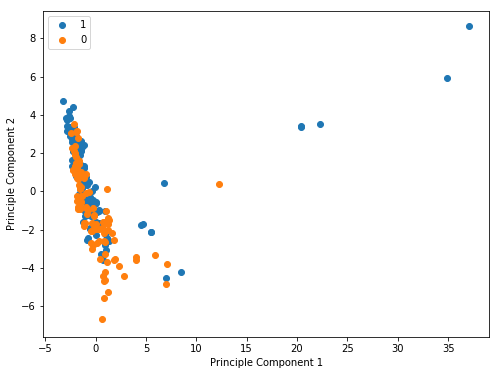

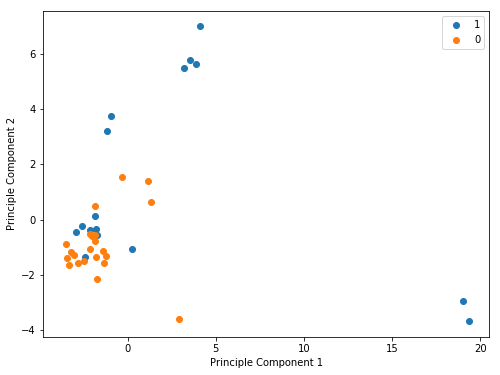

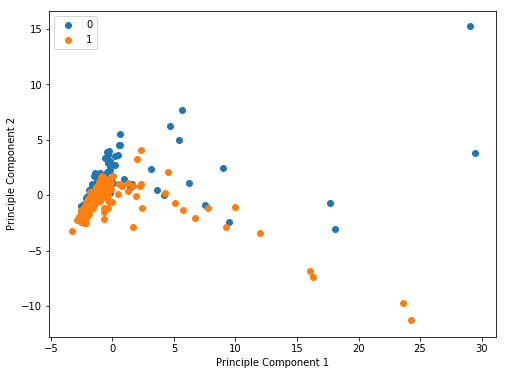

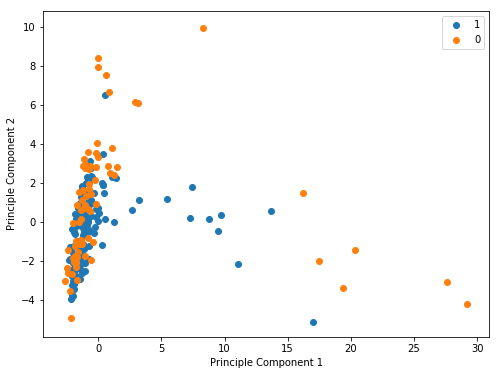

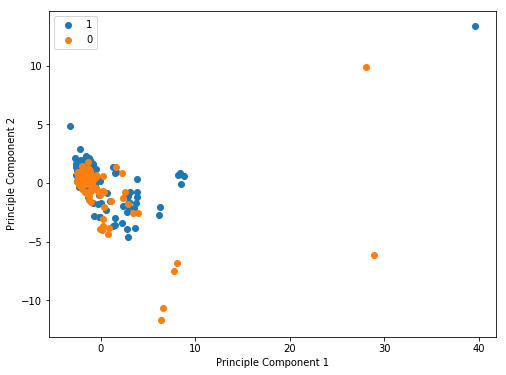

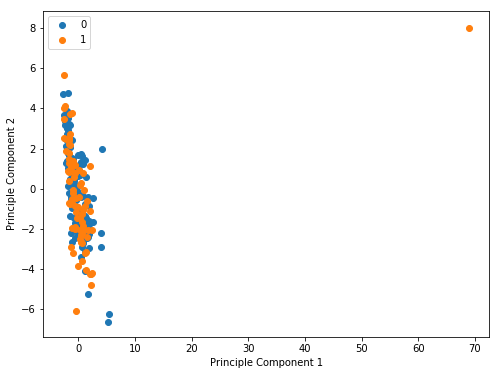

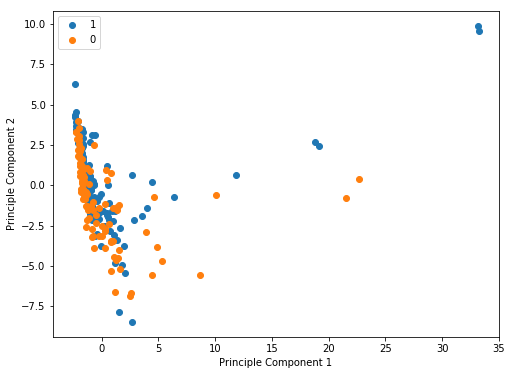

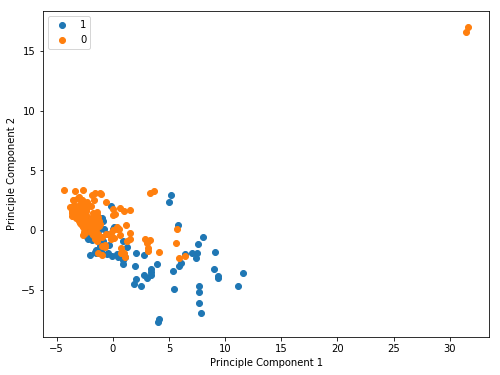

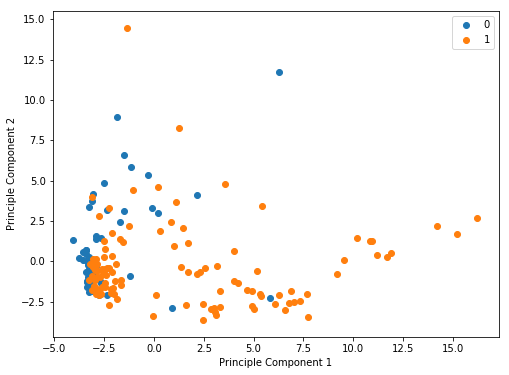

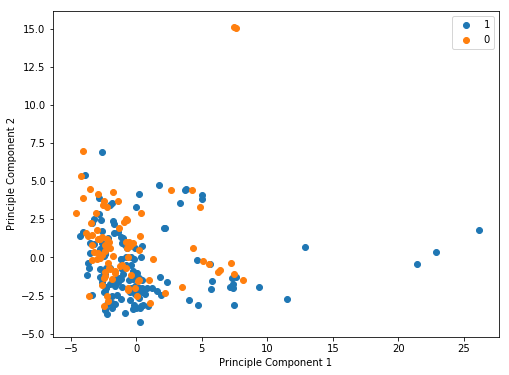

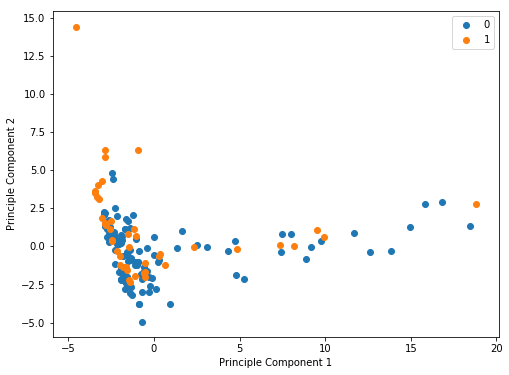

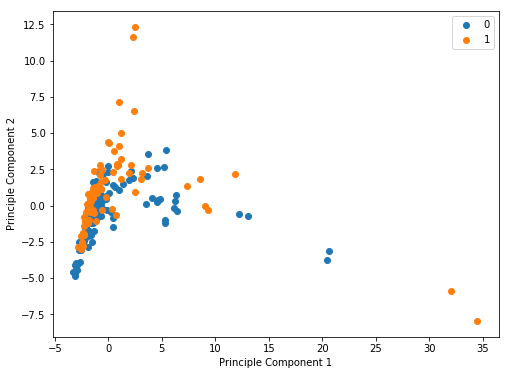

In [59]:
### TASKS
# tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt']
# tasks = ['RamL', 'RamR']
# tasks = ['FtnL', 'FtnR']
tasks = ['Sitng', 'Stndg', 'Drwg']
# tasks = ['Wlkg', 'WlkgCnt']
# tasks = ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']

### NEWLAB, GROUPS
# newLab, groups = ['Excld', 'Ram', 'Ftn', 'Rest', 'Wlkg', 'FinMot'], [['SitStand'], ['RamL', 'RamR'], ['FtnL', 'FtnR'], ['Sitng', 'Stndg', 'Drwg'], ['Wlkg', 'WlkgCnt'], ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']]
newLab, groups = ['NoSymp', 'Symp'], [[float(0)], [float(1), float(2), float(3), float(4)]]
# newLab, groups = [], []

### LABEL_TYPE
# label_type = 'TaskAbb'
label_type = 'Tremor'
# label_type = 'Bradykinesia'
# label_type = 'Dyskinesia'
# label_type = 'Overall'

bestFeatIdx = []

## RERUN MODEL WITH ONLY N MOST IMPORTANT FEATURES
# model, FeatImp = TrainTestModel(label_type, tasks, newLab, groups, bestFeatIdx)
# AvgFeatImp = np.mean(FeatImp, axis = 0)
# bestFeatIdx = list(AvgFeatImp.argsort()[-10:][::-1])

DataClusters, km = TrainTestCluster(label_type, tasks, newLab, groups, bestFeatIdx)

In [46]:
DataClusters.head()

,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,Cluster,RMSX,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
0,1003.0,0,Wlkg,0,0.0,3.0,0.0,3.0,1,0.005244,...,1.534573,1.135104,1.247825,0.003271,0.220259,0.038906,0.033755,1.643259,3.842972,0.020384
1,1003.0,0,Wlkg,1,0.0,3.0,0.0,3.0,0,0.005454,...,1.496998,0.911836,1.315564,0.003930,0.220102,0.049206,0.037547,1.194066,1.743819,0.020315
2,1003.0,0,Wlkg,2,0.0,3.0,0.0,3.0,0,0.005452,...,1.232808,0.836499,1.320286,0.003747,0.186121,0.047366,0.035179,1.187797,1.444953,0.020852
3,1003.0,0,Wlkg,3,0.0,3.0,0.0,3.0,0,0.004945,...,1.186462,0.956853,1.167309,0.002973,0.188598,0.035529,0.030486,1.599259,3.415395,0.024021
4,1003.0,0,Wlkg,4,0.0,3.0,0.0,3.0,1,0.005035,...,1.296650,1.098612,1.205879,0.001800,0.120177,0.020726,0.019261,2.136254,5.442004,0.018488


In [53]:
len(newLab)

6